In [5]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

## 0. Prepare data

In [6]:
data = pd.DataFrame(load_iris()['data'],columns=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'])
data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## 1. Class inheritance from `BaseEstimator` and `TransformerMixin`

In [7]:
class OutlierRemover(BaseEstimator,TransformerMixin):
    def __init__(self,factor=1.5):
        self.factor = factor
        
    def outlier_detector(self,X,y=None):
        X = pd.Series(X).copy()
        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1
        self.lower_bound.append(q1 - (self.factor * iqr))
        self.upper_bound.append(q3 + (self.factor * iqr))

    def fit(self,X,y=None):
        self.lower_bound = []
        self.upper_bound = []
        X.apply(self.outlier_detector)
        return self
    
    def transform(self,X,y=None):
        X = pd.DataFrame(X).copy()
        for i in range(X.shape[1]):
            x = X.iloc[:, i].copy()
            x[(x < self.lower_bound[i]) | (x > self.upper_bound[i])] = np.nan
            X.iloc[:, i] = x
        return X

#### Explaination:

Class named `OutlierRemover` which is our custom transformer to remove outliers i.e. replace outliers with NaN.
The class has three methods, namely, `outlier_removal`, `fit` and `transform`. Inheriting `BaseEstimator` and `TransformerMixin` classes adds three more methods, namely, `fit_transform`, `get_params` and `set_params`. We’ve also created an instance named `outlier_remover` of the `OutlierRemover` class.

- If `y=None`: the custom transformer do not transform y (targert value).
- If `y!=None`: the customer transformer transform both X (input value) and y (target value).

In [8]:
outlier_remover = OutlierRemover()

In [9]:
test = pd.DataFrame({'col1':[100,200,300,999],'col2':[0,0,1,2],'col3':[-10,0,1,2]})
test

,col1,col2,col3
0,100,0,-10
1,200,0,0
2,300,1,1
3,999,2,2


In [10]:
outlier_remover.fit(test)

OutlierRemover()

In [11]:
outlier_remover.transform(test)

,col1,col2,col3
0,100.0,0,NaN
1,200.0,0,0.0
2,300.0,1,1.0
3,NaN,2,2.0


We can use `fit_transform`. This gives the same result as the one above.

In [12]:
outlier_remover.fit_transform(test)

,col1,col2,col3
0,100.0,0,NaN
1,200.0,0,0.0
2,300.0,1,1.0
3,NaN,2,2.0


Visualize data with outliers

SepalLengthCm       AxesSubplot(0.125,0.125;0.168478x0.755)
SepalWidthCm     AxesSubplot(0.327174,0.125;0.168478x0.755)
PetalLengthCm    AxesSubplot(0.529348,0.125;0.168478x0.755)
PetalWidthCm     AxesSubplot(0.731522,0.125;0.168478x0.755)
dtype: object

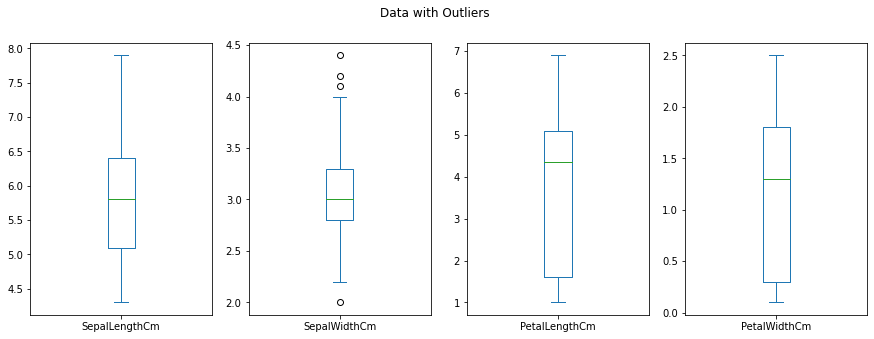

In [13]:
data.plot(kind="box",subplots=True,figsize=(15,5),title="Data with Outliers")

In [14]:
outlier_remover = OutlierRemover()

#ColumnTransformer to remove outliers
ct = ColumnTransformer(transformers=[['outlier_remover',OutlierRemover(),list(range(data.shape[1]))]],remainder='passthrough')

#iris data after outlier removal
data_without_outliers = pd.DataFrame(ct.fit_transform(data),columns=data.columns)

SepalLengthCm       AxesSubplot(0.125,0.125;0.168478x0.755)
SepalWidthCm     AxesSubplot(0.327174,0.125;0.168478x0.755)
PetalLengthCm    AxesSubplot(0.529348,0.125;0.168478x0.755)
PetalWidthCm     AxesSubplot(0.731522,0.125;0.168478x0.755)
dtype: object

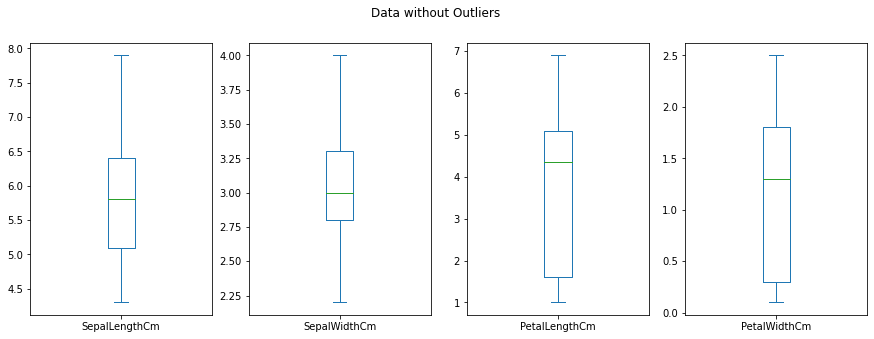

In [15]:
#iris data box plot after outlier removal
data_without_outliers.plot(kind="box",subplots=True,figsize=(15,5),title="Data without Outliers")

In the above box plot, we can see that the outliers in the column `SepalWidthCm` are removed i.e. replaced with NaN. We’ll find out how many and which outliers were removed from each column.

In [16]:
# 4 outliers are removed from SepalWidthCm, other columns stayed the same as they have no outliers.
data_without_outliers.isnull().sum()

SepalLengthCm    0
SepalWidthCm     4
PetalLengthCm    0
PetalWidthCm     0
dtype: int64

In [17]:
#outliers removed from sepal width (cm)
list(data.loc[data_without_outliers.isnull().sum(axis=1)>0,'SepalWidthCm'])

[4.4, 4.1, 4.2, 2.0]

## 2. Complete data pipline

In [18]:
X = data.copy()
y = load_iris()['target'].copy()

In [19]:
#Pipeline with outlier remover, imputer and regressor
pipeline = Pipeline(steps=[
                        ['outlier_removal',ct],
                        ['imputer',SimpleImputer()],
                        ['regressor',LogisticRegression(max_iter=1000)]
                        ]
                    ) 

We will tune the hyperparameters using `GridSearchCV`

In [28]:
param_grid = {'outlier_removal__outlier_remover__factor':[0,1,2,3,4],
              'imputer__strategy':['mean','median','most_frequent'],
              'regressor__C':[0.01,0.1,1,10,100]}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=3)

- To see the all approriate keys in `GridSearchCV`

In [27]:
gs.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__outlier_removal', 'estimator__imputer', 'estimator__regressor', 'estimator__outlier_removal__n_jobs', 'estimator__outlier_removal__remainder', 'estimator__outlier_removal__sparse_threshold', 'estimator__outlier_removal__transformer_weights', 'estimator__outlier_removal__transformers', 'estimator__outlier_removal__verbose', 'estimator__outlier_removal__verbose_feature_names_out', 'estimator__outlier_removal__outlier_remover', 'estimator__outlier_removal__outlier_remover__factor', 'estimator__imputer__add_indicator', 'estimator__imputer__copy', 'estimator__imputer__fill_value', 'estimator__imputer__missing_values', 'estimator__imputer__strategy', 'estimator__imputer__verbose', 'estimator__regressor__C', 'estimator__regressor__class_weight', 'estimator__regressor__dual', 'estimator__regressor__fit_intercept', 'estimator__regressor__intercept_scaling', 'estimator__regressor__l1_ratio'

In [29]:
gs.fit(X,y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[['outlier_removal',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[['outlier_remover',
                                                                         OutlierRemover(),
                                                                         [0, 1,
                                                                          2,
                                                                          3]]])],
                                       ['imputer', SimpleImputer()],
                                       ['regressor',
                                        LogisticRegression(max_iter=1000)]]),
             param_grid={'imputer__strategy': ['mean', 'median',
                                               'most_frequent'],
                         'outlier_removal__outlier_remover__factor': [0, 1, 2,
                                                                      3, 4],
                         'regressor__C': [0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [77]:
gs.best_params_

{'imputer__strategy': 'mean',
 'outlier_removal__outlier_remover__factor': 2,
 'regressor__C': 1}

### Alternative way

In [70]:
pipeline = make_pipeline(
                        OutlierRemover(),
                        SimpleImputer(),
                        LogisticRegression(max_iter=1000)                
                    ) 

In [71]:
param_grid = {'outlierremover__factor': [0,1,2,3,4],
              'simpleimputer__strategy': ['mean','median','most_frequent'],
              'logisticregression__C': [0.01,0.1,1,10,100]}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=3)

In [72]:
gs.fit(X,y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('outlierremover', OutlierRemover()),
                                       ('simpleimputer', SimpleImputer()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100],
                         'outlierremover__factor': [0, 1, 2, 3, 4],
                         'simpleimputer__strategy': ['mean', 'median',
                                                     'most_frequent']},
             scoring='accuracy')

In [73]:
gs.best_params_

{'logisticregression__C': 1,
 'outlierremover__factor': 2,
 'simpleimputer__strategy': 'mean'}